
Processing setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Found 28 users in setting 'vf_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
17 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 89.4% ±  2.4%	  8.2% ±  2.1%	 77.8% ± 10.1%	+0.059 ± 0.025
With Explanation         	 25.9% ±  3.4%	 46.5% ±  3.8%	 62.7% ±  4.3%	+0.188 ± 0.065
With Explanation + Quality	  7.6% ±  2.0%	 57.1% ±  3.8%	 61.8% ±  3.9%	+0.218 ± 0.072
89.4% ± 2.4%, 8.2% ± 2.1%, 77.8% ± 10.1%, 0.059 ± 0.025, 25.9% ± 3.4%, 46.5% ± 3.8%, 62.7% ± 4.3%, 0.188 ± 0.065, 7.6% ± 2.0%, 57.1% ± 3.8%, 61.8% ± 3.9%, 0.218 ± 0.072

Setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  25.9%		 +0.129 ± 0.065
Quality		   7.6%		 +0.029 ± 0.048

Setting: vf

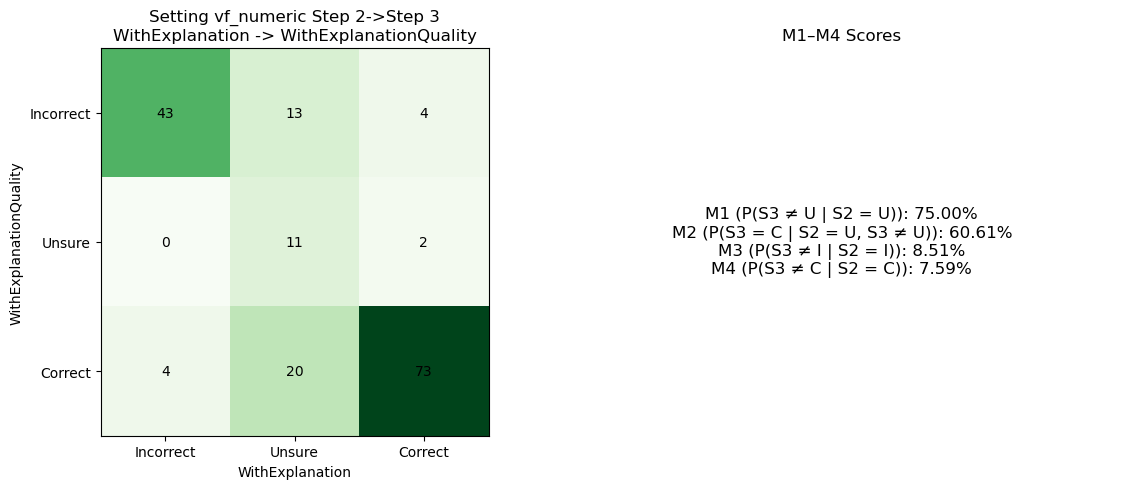


Processing setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
16 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 92.5% ±  2.1%	  6.9% ±  2.0%	 91.7% ±  8.3%	+0.062 ± 0.021
With Explanation         	 26.9% ±  3.5%	 44.4% ±  3.9%	 60.7% ±  4.5%	+0.156 ± 0.067
With Explanation + Quality	  8.1% ±  2.2%	 54.4% ±  4.0%	 59.2% ±  4.1%	+0.169 ± 0.075
92.5% ± 2.1%, 6.9% ± 2.0%, 91.7% ± 8.3%, 0.062 ± 0.021, 26.9% ± 3.5%, 44.4% ± 3.9%, 60.7% ± 4.5%, 0.156 ± 0.067, 8.1% ± 2.2%, 54.4% ± 4.0%, 59.2% ± 4.1%, 0.169 ± 0.075

Setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  26.9%		 +0.094 ± 0.066
Quality		   8.1%		 +0.013 ± 0.051

Set

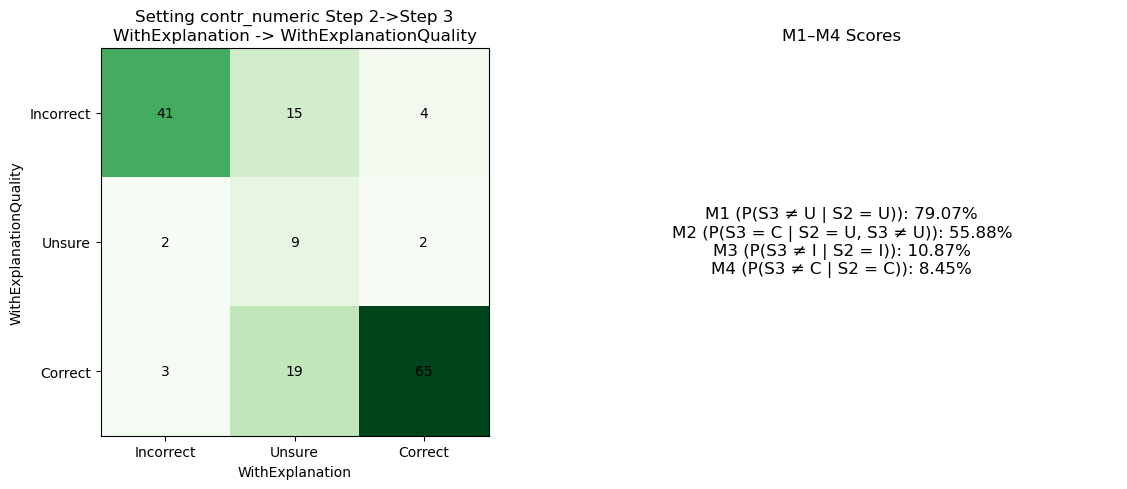


Processing setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'showbothmetrics_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
17 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 94.4% ±  1.7%	  3.9% ±  1.4%	 70.0% ± 15.3%	+0.022 ± 0.018
With Explanation         	 50.0% ±  3.7%	 27.8% ±  3.3%	 55.6% ±  5.3%	+0.056 ± 0.053
With Explanation + Quality	 11.1% ±  2.3%	 57.2% ±  3.7%	 64.4% ±  3.8%	+0.256 ± 0.068
94.4% ± 1.7%, 3.9% ± 1.4%, 70.0% ± 15.3%, 0.022 ± 0.018, 50.0% ± 3.7%, 27.8% ± 3.3%, 55.6% ± 5.3%, 0.056 ± 0.053, 11.1% ± 2.3%, 57.2% ± 3.7%, 64.4% ± 3.8%, 0.256 ± 0.068

Setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  50.0%		 +0.033 ± 0.052
Quality		  11.1%		 +0.200 ± 0.

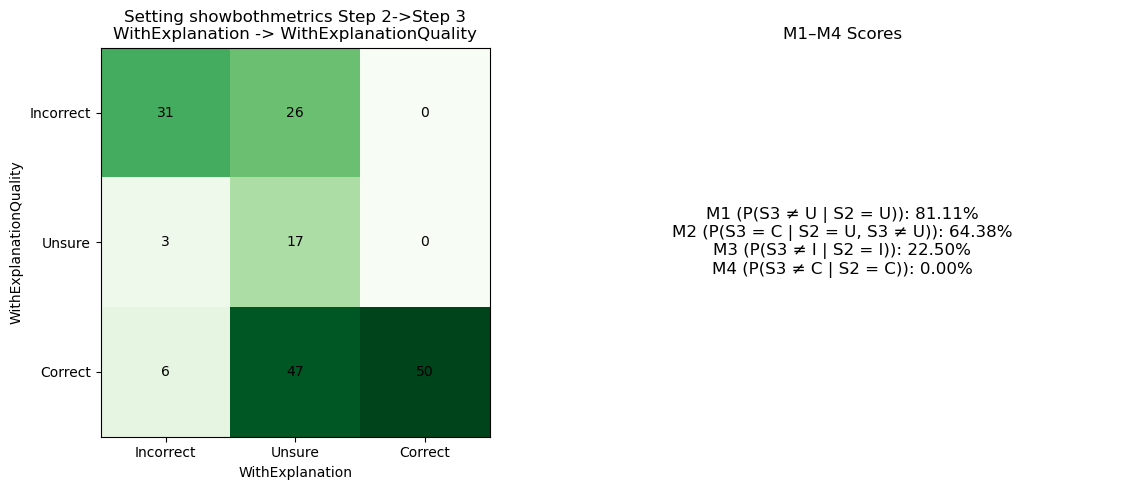


Processing setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Found 31 users in setting 'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
23 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 95.7% ±  1.3%	  2.2% ±  1.0%	 50.0% ± 16.7%	+0.000 ± 0.014
With Explanation         	 41.7% ±  3.3%	 38.7% ±  3.2%	 66.4% ±  4.1%	+0.191 ± 0.049
With Explanation + Quality	  6.1% ±  1.6%	 60.0% ±  3.2%	 63.9% ±  3.3%	+0.261 ± 0.062
95.7% ± 1.3%, 2.2% ± 1.0%, 50.0% ± 16.7%, 0.000 ± 0.014, 41.7% ± 3.3%, 38.7% ± 3.2%, 66.4% ± 4.1%, 0.191 ± 0.049, 6.1% ± 1.6%, 60.0% ± 3.2%, 63.9% ± 3.3%, 0.261 ± 0.062

Setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  41.7%		 +0.191 ± 0.049
Quality		   6.1%

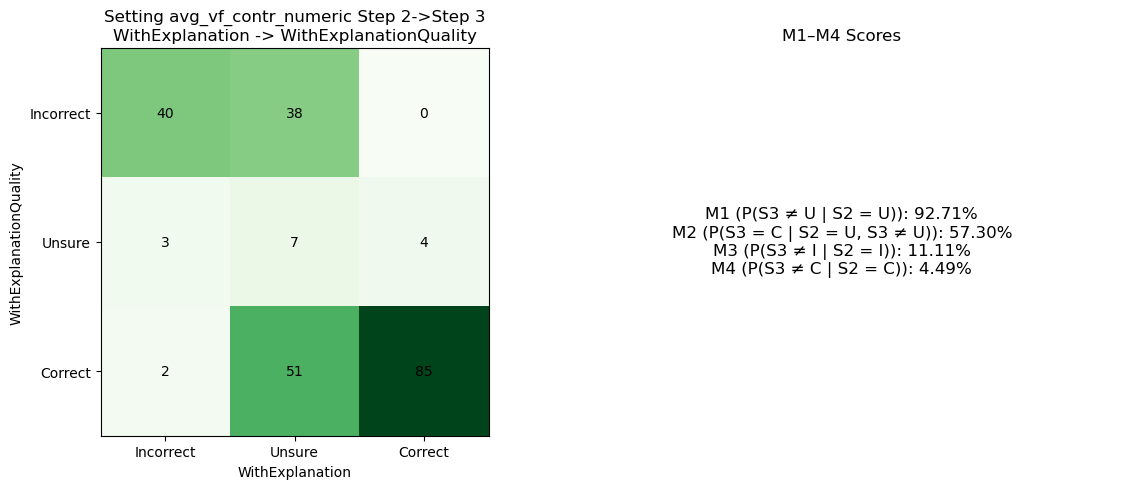


Processing setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Found 26 users in setting 'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0' with 29 total attempts.
14 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 92.0% ±  2.2%	  4.7% ±  1.7%	 58.3% ± 14.9%	+0.013 ± 0.023
With Explanation         	 35.3% ±  3.9%	 42.7% ±  4.1%	 66.0% ±  4.8%	+0.207 ± 0.064
With Explanation + Quality	  5.3% ±  1.8%	 59.3% ±  4.0%	 62.7% ±  4.1%	+0.240 ± 0.077
92.0% ± 2.2%, 4.7% ± 1.7%, 58.3% ± 14.9%, 0.013 ± 0.023, 35.3% ± 3.9%, 42.7% ± 4.1%, 66.0% ± 4.8%, 0.207 ± 0.064, 5.3% ± 1.8%, 59.3% ± 4.0%, 62.7% ± 4.1%, 0.240 ± 0.077

Setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  35.3%		 +0.193 ± 0

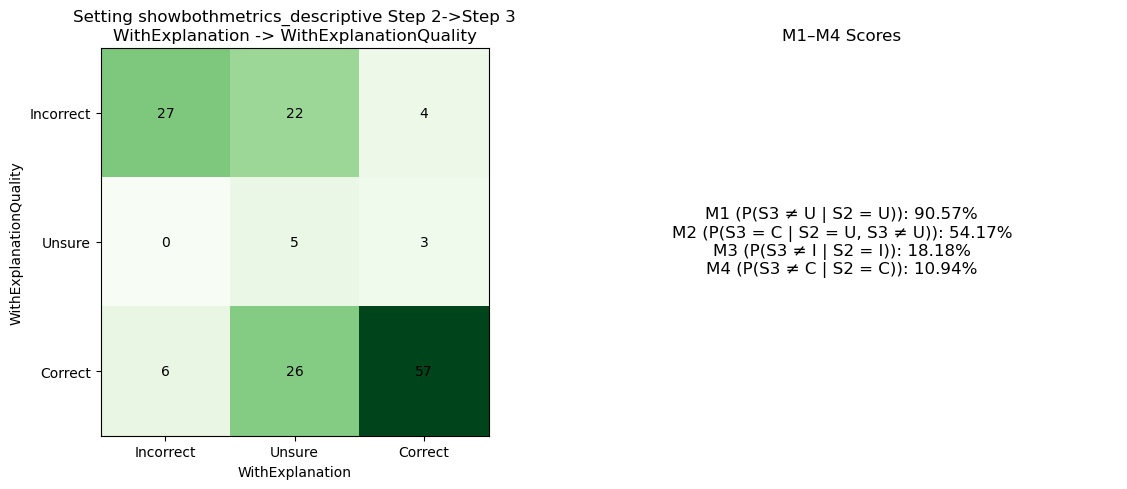


Processing setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'vf_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
17 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 95.9% ±  1.5%	  2.4% ±  1.2%	 57.1% ± 20.2%	+0.006 ± 0.016
With Explanation         	 30.6% ±  3.5%	 38.2% ±  3.7%	 55.1% ±  4.6%	+0.071 ± 0.064
With Explanation + Quality	  4.7% ±  1.6%	 58.2% ±  3.8%	 61.1% ±  3.8%	+0.212 ± 0.073
95.9% ± 1.5%, 2.4% ± 1.2%, 57.1% ± 20.2%, 0.006 ± 0.016, 30.6% ± 3.5%, 38.2% ± 3.7%, 55.1% ± 4.6%, 0.071 ± 0.064, 4.7% ± 1.6%, 58.2% ± 3.8%, 61.1% ± 3.8%, 0.212 ± 0.073

Setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  30.6%		 +0.065 ± 0.064
Quality		   4.7%		 +0.141 ± 0.059


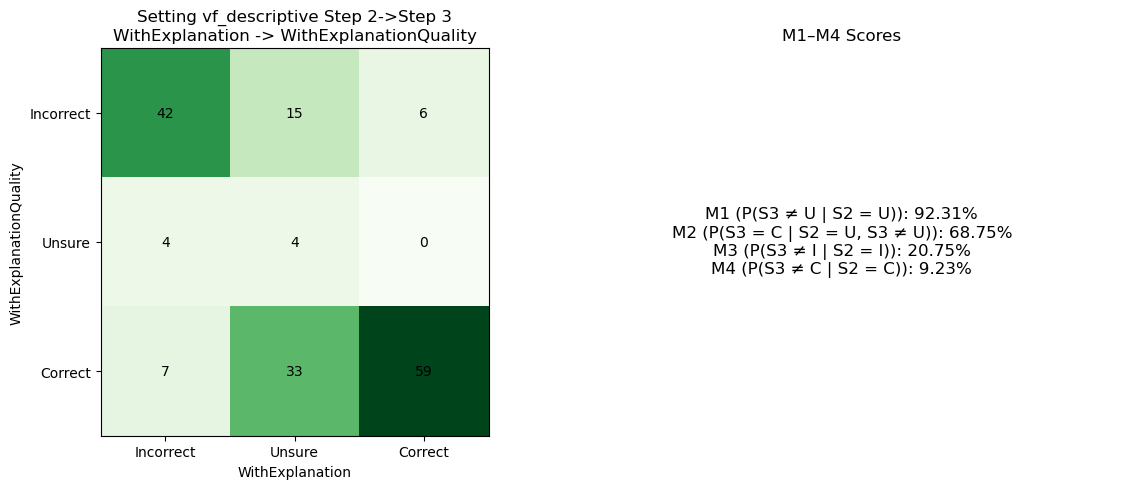


Processing setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
14 users remain after filtering (>=20% unsure in Answer Only).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 89.3% ±  2.6%	  6.4% ±  2.1%	 60.0% ± 13.1%	+0.021 ± 0.028
With Explanation         	 12.1% ±  2.8%	 56.4% ±  4.2%	 64.2% ±  4.3%	+0.250 ± 0.077
With Explanation + Quality	  7.9% ±  2.3%	 57.1% ±  4.2%	 62.0% ±  4.3%	+0.221 ± 0.079
89.3% ± 2.6%, 6.4% ± 2.1%, 60.0% ± 13.1%, 0.021 ± 0.028, 12.1% ± 2.8%, 56.4% ± 4.2%, 64.2% ± 4.3%, 0.250 ± 0.077, 7.9% ± 2.3%, 57.1% ± 4.2%, 62.0% ± 4.3%, 0.221 ± 0.079

Setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  12.1%		 +0.229 ± 0.073
Quality		   7.9%		 -0.029

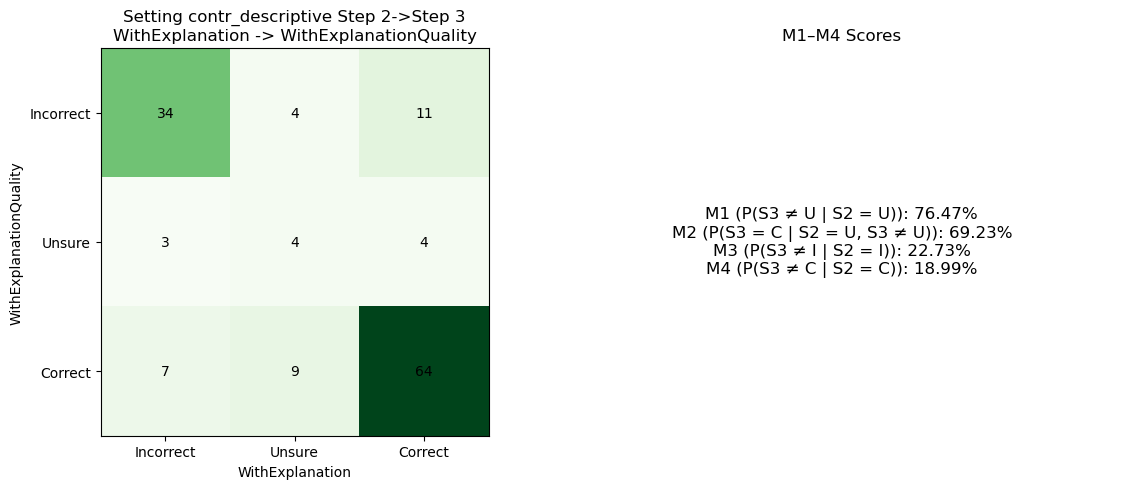

/tmp/ipykernel_101425/2658346951.py:323: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])


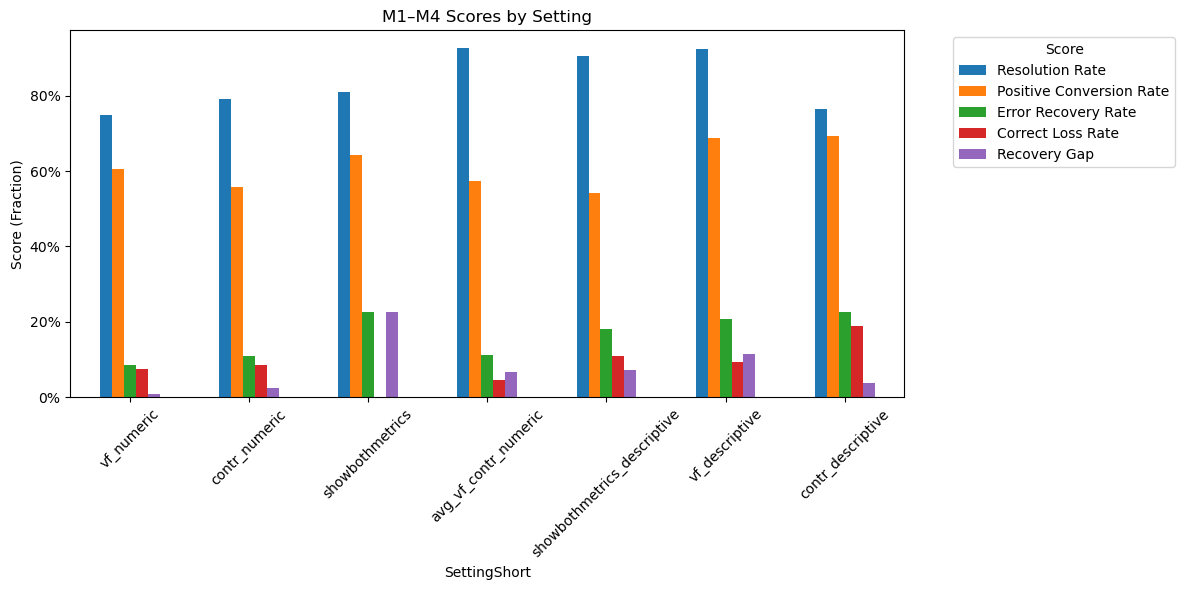

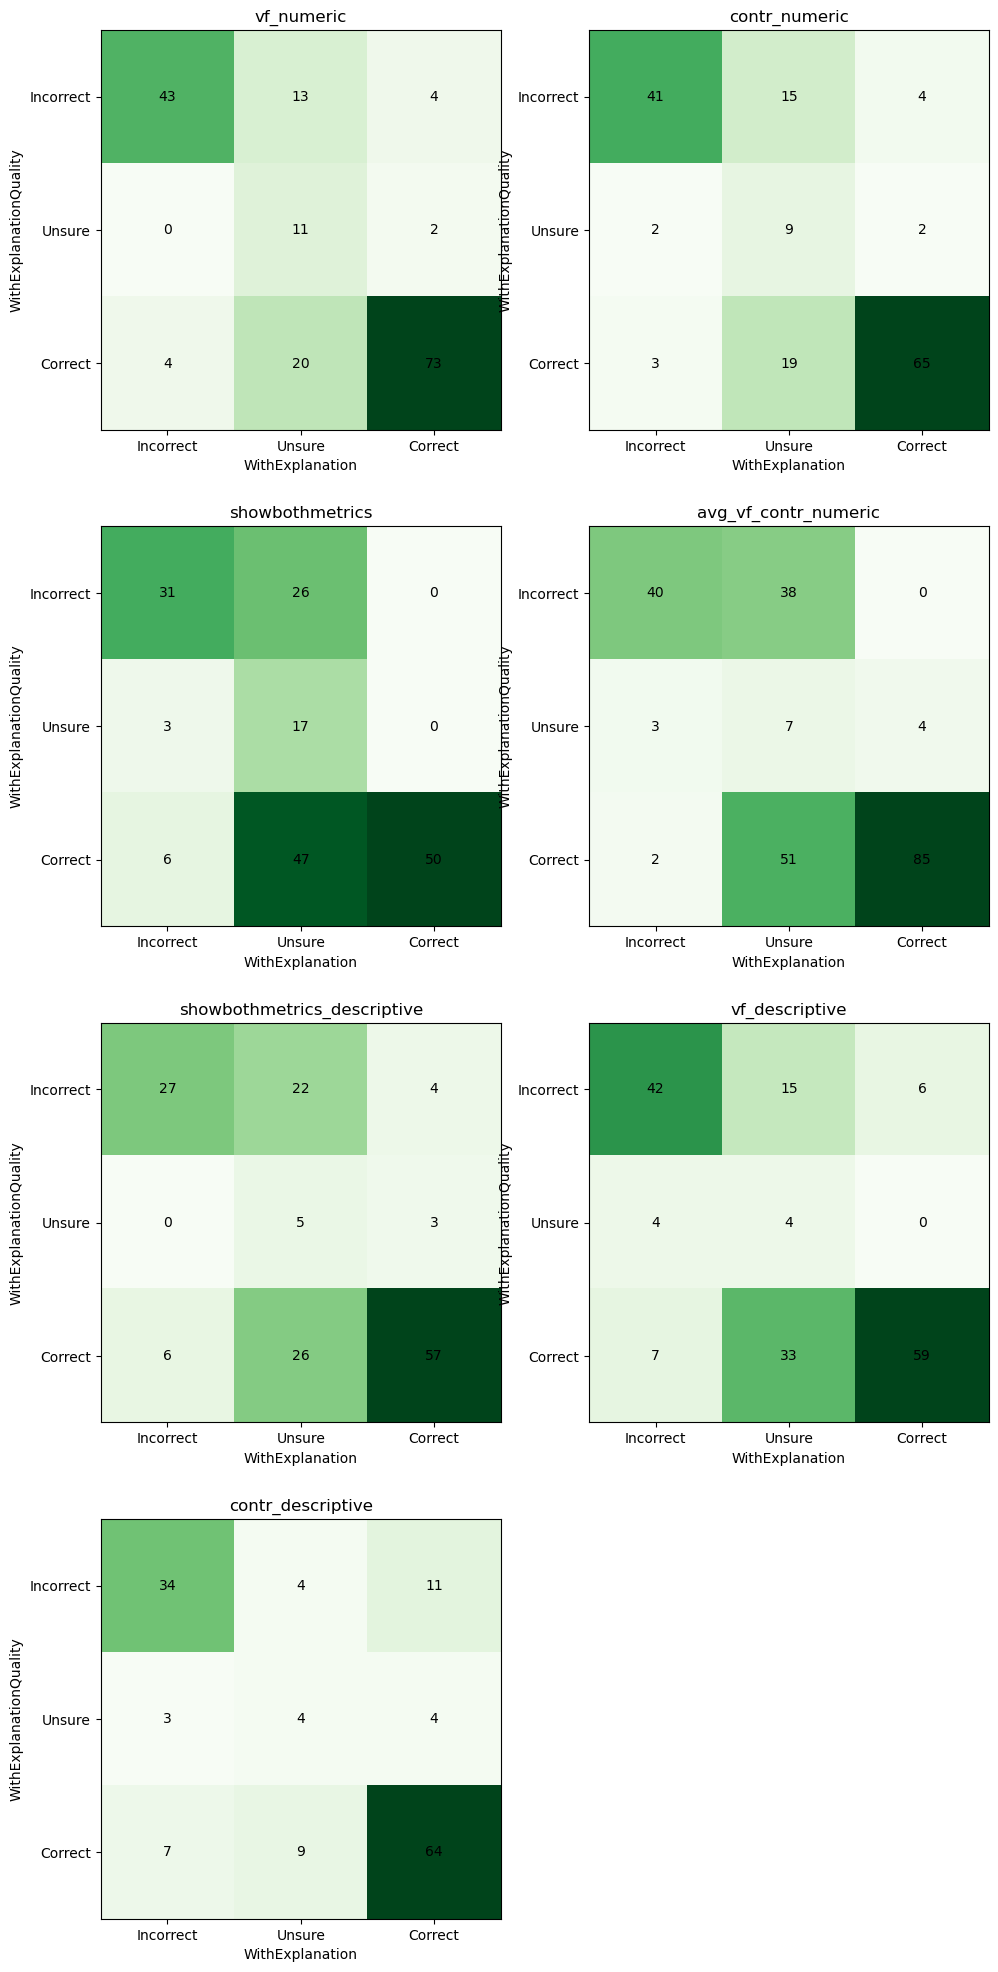

In [5]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# Filter: only include users with a certain unsure rate in 'answeronly' stage.
unsure_rate_threshold = 0.8

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(values):
    """Return the standard error of the given values."""
    n = len(values)
    return np.std(values, ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_unsure_rate(interactions, stage):
    """Compute the unsure rate (proportion of responses == 2) and its standard error."""
    preds = np.array([x['user_selections'][stage] for x in interactions])
    unsure_indicator = (preds == 2).astype(float)
    mean_unsure = np.mean(unsure_indicator)
    se_unsure = compute_se(unsure_indicator)
    return mean_unsure, se_unsure

def evaluate_answers(stage, instances):
    """
    For a given stage and list of interactions (instances), compute:
      - total accuracy (all instances, counting unsure as incorrect)
      - accuracy on non-unsure responses ("NotUnsureAcc")
      - unsure rate
      - utility (0 if unsure, 1 if correct, -1 if incorrect)
    Returns means and standard errors.
    """
    # Ground truth: 0 means AI is correct; 1 means AI is incorrect.
    ground_truths = np.array([1 - x['question']['prediction_is_correct'] for x in instances])
    preds = np.array([x['user_selections'][stage] for x in instances])
    
    # Total accuracy: count unsure (value 2) as incorrect.
    correct_all = ((preds != 2) & (preds == ground_truths)).astype(float)
    total_acc_mean = np.mean(correct_all)
    total_acc_se = compute_se(correct_all)
    
    # Accuracy for non-unsure responses.
    non_unsure_mask = (preds != 2)
    if np.sum(non_unsure_mask) > 0:
        correct_non_unsure = (preds[non_unsure_mask] == ground_truths[non_unsure_mask]).astype(float)
        acc_mean = np.mean(correct_non_unsure)
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan
    
    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_rate_mean = np.mean(unsure_indicator)
    unsure_rate_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; 1 if correct; -1 if incorrect.
    individual_utilities = np.array([
        0 if p == 2 else 1 - 2 * abs(p - gt)
        for p, gt in zip(preds, ground_truths)
    ])
    util_mean = np.mean(individual_utilities)
    util_se = compute_se(individual_utilities)
    
    return {
        'total_accuracy_mean': total_acc_mean,
        'total_accuracy_se': total_acc_se,
        'accuracy_mean': acc_mean,
        'accuracy_se': acc_se,
        'unsure_rate_mean': unsure_rate_mean,
        'unsure_rate_se': unsure_rate_se,
        'utility_mean': util_mean,
        'utility_se': util_se,
        'preds': preds,
        'ground_truths': ground_truths,
        'individual_utilities': individual_utilities,
    }

# ---------------------------
# Settings & Data Processing
# ---------------------------
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
]

USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# This list will collect the M1–M4 scores for each setting.
all_setting_scores = []

# This list will collect the confusion matrices for each setting.
all_confusion_matrices = []

# Process each setting.
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Aggregate sessions for each user.
    data = {}  # key: user_id, value: list of sessions
    for file in files:
        with open(file) as f:
            batch_data = json.load(f)
            for user_id, session in batch_data.items():
                data.setdefault(user_id, []).append(session)
    total_users = len(data)
    total_attempts = sum(len(sessions) for sessions in data.values())
    print(f"Found {total_users} users in setting '{setting}' with {total_attempts} total attempts.")
    
    filtered_instances = []
    count_filtered_users = 0
    for user, sessions in data.items():
        interactions = []
        for session in sessions:
            interactions.extend(session['interactions'])
        mean_unsure, _ = compute_unsure_rate(interactions, 'answeronly')
        if mean_unsure >= unsure_rate_threshold:
            filtered_instances.extend(interactions)
            count_filtered_users += 1
    print(f"{count_filtered_users} users remain after filtering.")
    
    if len(filtered_instances) == 0:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue

    # Evaluate each stage.
    answeronly_results = evaluate_answers('answeronly', filtered_instances)
    withexplanation_results = evaluate_answers('withexplanation', filtered_instances)
    withexplanationquality_results = evaluate_answers('withexplanationquality', filtered_instances)
    
    # ---------------------------
    # 1. Print Per-Stage Scores
    # ---------------------------
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    print("-" * 100)
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stage_results = [answeronly_results, withexplanation_results, withexplanationquality_results]
    
    csv_prints = [] # For copiable csv outputs
    for name, res in zip(stage_names, stage_results):
        # Multiply rates by 100 for percentage printing.
        print(f"{name:<25}\t"
              f"{res['unsure_rate_mean']*100:5.1f}% ± {res['unsure_rate_se']*100:4.1f}%\t"
              f"{res['total_accuracy_mean']*100:5.1f}% ± {res['total_accuracy_se']*100:4.1f}%\t"
              f"{res['accuracy_mean']*100:5.1f}% ± {res['accuracy_se']*100:4.1f}%\t"
              f"{res['utility_mean']:+.3f} ± {res['utility_se']:.3f}")
        csv_prints.append(f"{res['unsure_rate_mean']*100:.1f}% ± {res['unsure_rate_se']*100:.1f}%, "
                            f"{res['total_accuracy_mean']*100:.1f}% ± {res['total_accuracy_se']*100:.1f}%, "
                            f"{res['accuracy_mean']*100:.1f}% ± {res['accuracy_se']*100:.1f}%, "
                            f"{res['utility_mean']:.3f} ± {res['utility_se']:.3f}")
        
    print(", ".join(csv_prints))
        
        
    
    # ---------------------------
    # 2. Print Utility Gains (Over Previous Stage)
    # ---------------------------
    # Compute differences for interactions (they align since we used the same filtered_instances).
    explanation_gain = withexplanation_results['individual_utilities'] - answeronly_results['individual_utilities']
    quality_gain = withexplanationquality_results['individual_utilities'] - withexplanation_results['individual_utilities']
    
    expl_gain_mean = np.mean(explanation_gain)
    expl_gain_se = compute_se(explanation_gain)
    qual_gain_mean = np.mean(quality_gain)
    qual_gain_se = compute_se(quality_gain)
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    # For the "Explanation" stage, print its unsure rate and the gain (compared to Answer Only).
    print(f"Explanation\t {withexplanation_results['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {withexplanationquality_results['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")

    # ---------------------------
    # 3. Compute Confusion Matrix & M1–M4 (Step 2 -> Step 3)
    # ---------------------------
    # Use the utility values from 'withexplanation' (stage2) and 'withexplanationquality' (stage3).
    # Define mapping: -1 -> row/col 0, 0 -> row/col 1, 1 -> row/col 2.
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']

    # Initialize a 3x3 confusion matrix.
    cm = np.zeros((3, 3), dtype=int)
    for u2, u3 in zip(withexplanation_results['individual_utilities'], 
                    withexplanationquality_results['individual_utilities']):
        cm[mapping[u2], mapping[u3]] += 1

    # For display only, transpose the confusion matrix.
    cm_transposed = cm.T

    # Print the transposed confusion matrix.
    print(f"\nSetting: {setting} Step 2->Step 3 (transposed)")
    header = "\t\t" + "\t".join(label_names)
    print(header)
    for i, label in enumerate(label_names):
        row_counts = "\t\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_counts}")
        
    # Store this confusion matrix for later plotting.
    all_confusion_matrices.append((setting, cm_transposed))

    # Helper: count transitions between given utility values (remains unchanged).
    def count_transitions(val2, val3):
        return sum(1 for u2, u3 in zip(withexplanation_results['individual_utilities'],
                                        withexplanationquality_results['individual_utilities'])
                if u2 == val2 and u3 == val3)

    # M1, M2, M3, M4 are computed as before.
    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    
    # Collect scores for the bar plot.
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    
    # ---------------------------
    # NEW: Print Examples where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    example_count = 0
    for interaction in filtered_instances:
        stage2_pred = interaction['user_selections'].get('withexplanation')
        stage3_pred = interaction['user_selections'].get('withexplanationquality')
        ground_truth = 1 - interaction['question']['prediction_is_correct']
        # Check that stage 2 (With Explanation) is not unsure and is correct,
        # and that stage 3 (With Explanation + Quality) is not unsure and is incorrect.
        if stage2_pred != 2 and stage2_pred == ground_truth and stage3_pred != 2 and stage3_pred != ground_truth:
            print(json.dumps(interaction, indent=2))
            example_count += 1
            if example_count >= 5:
                break
    if example_count == 0:
        print("No examples found.")

    # ---------------------------
    # 4. Plot Transposed Confusion Matrix & M1–M4 Scores
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot the transposed confusion matrix.
    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\nWithExplanation -> WithExplanationQuality")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    # After transposition, the x-axis corresponds to the original stage2 labels,
    # and the y-axis to stage3 labels.
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    # Annotate each cell.
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")

    # Plot M1–M4 scores in a text panel.
    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")

    plt.tight_layout()
    plt.show()

# ---------------------------
# 5. Plot Bar Plot for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    
    # Add new column: Recovery Gap = Error Recovery Rate (M3) - Correct Loss Rate (M4)
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    
    df_scores = df_scores.set_index("SettingShort")
    
    # Create a grouped bar plot.
    ax = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate", "Correct Loss Rate", "Recovery Gap"]].plot(
        kind='bar', figsize=(12, 6)
    )
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("M1–M4 Scores by Setting")
    # Format the y-axis as percentage if desired.
    vals = ax.get_yticks()
    ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])
    # rotate x-tick labels for better readability.
    plt.xticks(rotation=45)
    
    plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
# ---------------------------
# 6. Plot a Large Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    # Determine grid dimensions: 2 columns and enough rows to cover all settings.
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    
    # Flatten the axes array for easy iteration.
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        # Annotate each cell.
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    # Hide any extra subplots if the grid is larger than the number of settings.
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()


Processing setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Found 28 users in setting 'vf_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
User 63fcfd81a075a45d1a821308 filtered out in batches ['003_3users']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
27 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 62.1% ±  5.2%	 26.4% ±  4.8%	 69.7% ±  8.1%	+0.149 ± 0.064
With Explanation         	 16.1% ±  4.0%	 57.5% ±  5.3%	 68.5% ±  5.5%	+0.310 ± 0.093
With Explanation + Quality	  4.6% ±  2.3%	 66.7% ±  5.1%	 69.9% ±  5.1%	+0.379 ± 0.097
62.1% ± 5.2%, 26.4% ± 4.8%, 69.7% ± 8.1%, 0.149 ± 0.064, 16.1% ± 4.0%, 57.5% ± 5.3%, 68.5% ± 5.5%, 0.310 ± 0.093, 4.6% ± 2.3%, 66.7% ± 5.1%, 69.9% ± 5.1%, 0.379 ± 0.097

Setting: vf_numeric_llava1.5

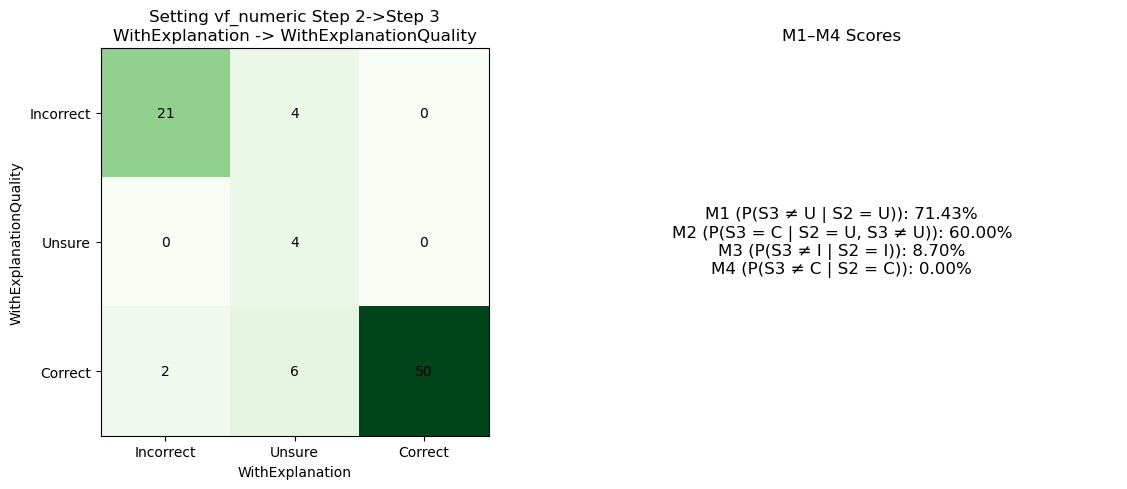


Processing setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
30 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 63.3% ±  5.1%	 23.3% ±  4.5%	 63.6% ±  8.5%	+0.100 ± 0.063
With Explanation         	 18.9% ±  4.1%	 48.9% ±  5.3%	 60.3% ±  5.8%	+0.167 ± 0.094
With Explanation + Quality	  7.8% ±  2.8%	 54.4% ±  5.3%	 59.0% ±  5.4%	+0.167 ± 0.100
63.3% ± 5.1%, 23.3% ± 4.5%, 63.6% ± 8.5%, 0.100 ± 0.063, 18.9% ± 4.1%, 48.9% ± 5.3%, 60.3% ± 5.8%, 0.167 ± 0.094, 7.8% ± 2.8%, 54.4% ± 5.3%, 59.0% ± 5.4%, 0.167 ± 0.100

Setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  18.9%		 +0.067 ± 0.082
Quality		   7.8%		 

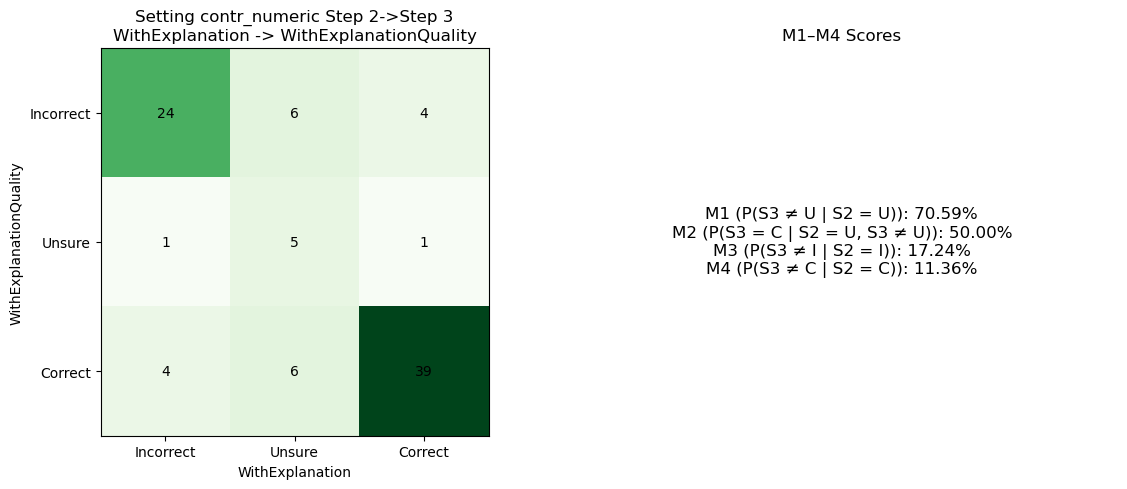


Processing setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'showbothmetrics_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
User 6658d3384552a75abbc15f10 filtered out in batches ['000']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
User 616c056b42e788ef31efc4b0 filtered out in batches ['003_3users']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
28 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 69.0% ±  5.0%	 19.5% ±  4.3%	 63.0% ±  9.5%	+0.080 ± 0.059
With Explanation         	 33.3% ±  5.1%	 39.1% ±  5.3%	 58.6% ±  6.5%	+0.115 ± 0.087
With Explanation + Quality	  5.7% ±  2.5%	 62.1% ±  5.2%	 65.9% ±  5.3%	+0.299 ± 0.100
69.0% ± 5.0%, 19.5% ± 4.3%, 63.0% ± 9.5%, 0.080 ± 0.059, 33.

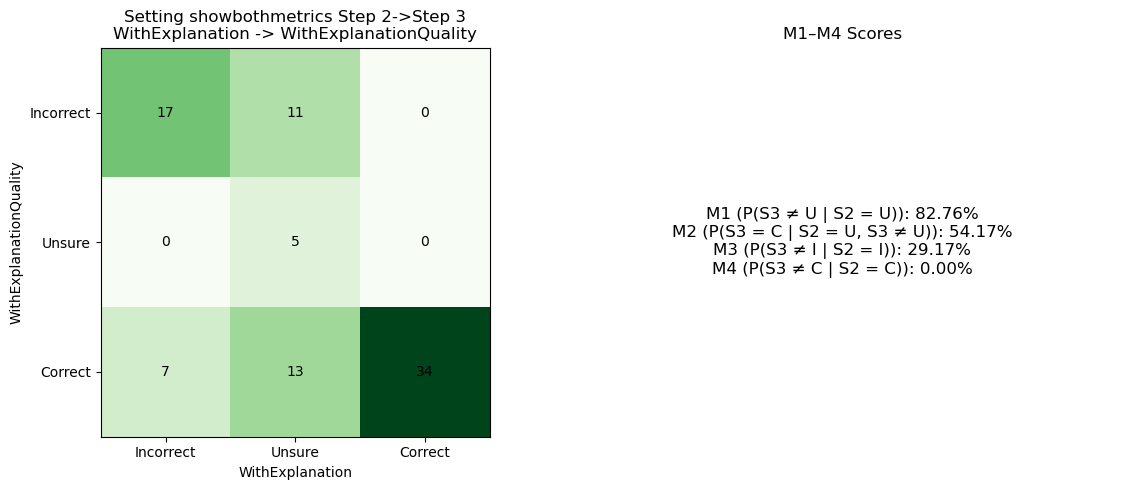


Processing setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Found 31 users in setting 'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
31 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 81.7% ±  4.0%	  6.5% ±  2.6%	 35.3% ± 11.9%	-0.054 ± 0.044
With Explanation         	 33.3% ±  4.9%	 35.5% ±  5.0%	 53.2% ±  6.4%	+0.043 ± 0.085
With Explanation + Quality	  5.4% ±  2.4%	 53.8% ±  5.2%	 56.8% ±  5.3%	+0.129 ± 0.101
81.7% ± 4.0%, 6.5% ± 2.6%, 35.3% ± 11.9%, -0.054 ± 0.044, 33.3% ± 4.9%, 35.5% ± 5.0%, 53.2% ± 6.4%, 0.043 ± 0.085, 5.4% ± 2.4%, 53.8% ± 5.2%, 56.8% ± 5.3%, 0.129 ± 0.101

Setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  33.3%		 +0.097 ± 0.0

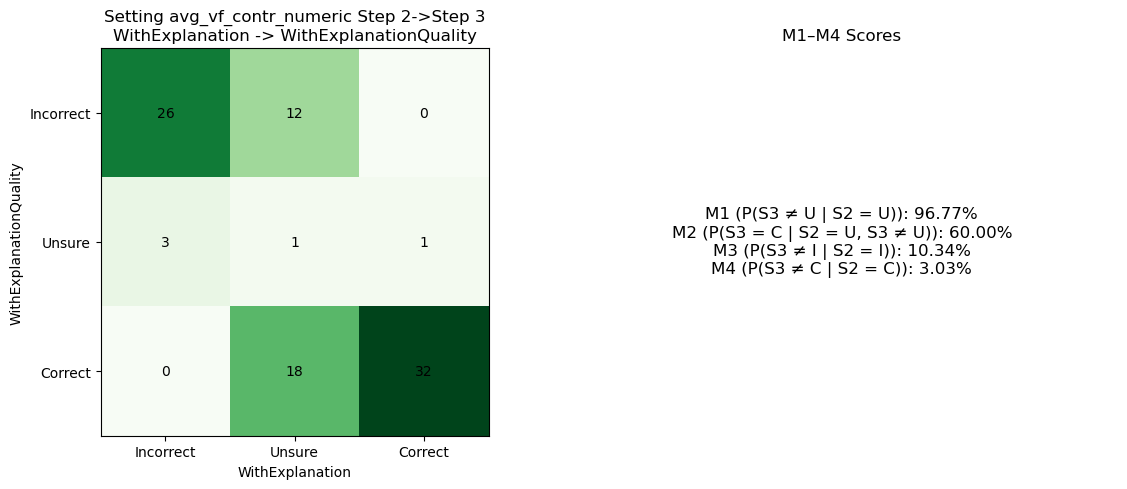


Processing setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Found 26 users in setting 'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0' with 29 total attempts.
26 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 66.7% ±  5.1%	 19.5% ±  4.3%	 58.6% ±  9.3%	+0.057 ± 0.062
With Explanation         	 17.2% ±  4.1%	 46.0% ±  5.4%	 55.6% ±  5.9%	+0.092 ± 0.098
With Explanation + Quality	  6.9% ±  2.7%	 59.8% ±  5.3%	 64.2% ±  5.4%	+0.264 ± 0.100
66.7% ± 5.1%, 19.5% ± 4.3%, 58.6% ± 9.3%, 0.057 ± 0.062, 17.2% ± 4.1%, 46.0% ± 5.4%, 55.6% ± 5.9%, 0.092 ± 0.098, 6.9% ± 2.7%, 59.8% ± 5.3%, 64.2% ± 5.4%, 0.264 ± 0.100

Setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  

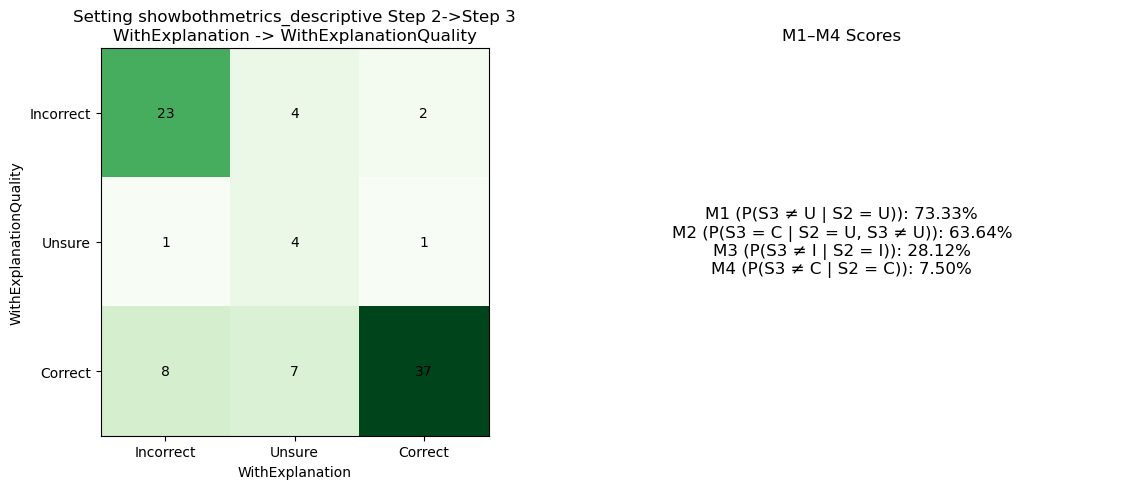


Processing setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'vf_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
User 65a7df7c16fa6566fcd54e4e filtered out in batches ['004_3users']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
User 66848988b8e42b559b702474 filtered out in batches ['004_3users']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
28 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 66.7% ±  5.2%	 20.2% ±  4.4%	 60.7% ±  9.4%	+0.071 ± 0.063
With Explanation         	 14.3% ±  3.8%	 48.8% ±  5.5%	 56.9% ±  5.9%	+0.119 ± 0.101
With Explanation + Quality	  2.4% ±  1.7%	 60.7% ±  5.4%	 62.2% ±  5.4%	+0.238 ± 0.105
66.7% ± 5.2%, 20.2% ± 4.4%, 60.7% ± 9.4%, 0.071 ± 0.063

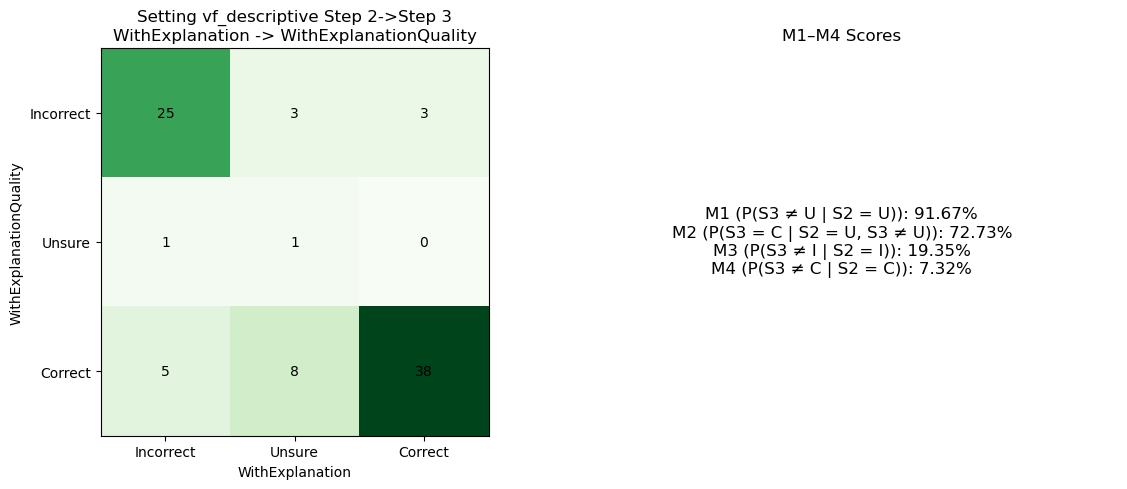


Processing setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
User 63d82b2de40f94ceb14816cc filtered out in batches ['004_3users']. Response distribution: {'0': '100.0%', '1': '0.0%', '2': '0.0%'}
29 users remain after filtering (no single response selected ≥ 90% of the time).

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 63.2% ±  5.2%	 23.0% ±  4.5%	 62.5% ±  8.7%	+0.092 ± 0.065
With Explanation         	 20.7% ±  4.4%	 46.0% ±  5.4%	 58.0% ±  6.0%	+0.126 ± 0.095
With Explanation + Quality	 10.3% ±  3.3%	 51.7% ±  5.4%	 57.7% ±  5.6%	+0.138 ± 0.101
63.2% ± 5.2%, 23.0% ± 4.5%, 62.5% ± 8.7%, 0.092 ± 0.065, 20.7% ± 4.4%, 46.0% ± 5.4%, 58.0% ± 6.0%, 0.126 ± 0.095, 10.3% ± 3.3%, 51.7% ± 5.4%, 57.7% ± 5.6%, 0.138 ± 0.101

Setting: cont

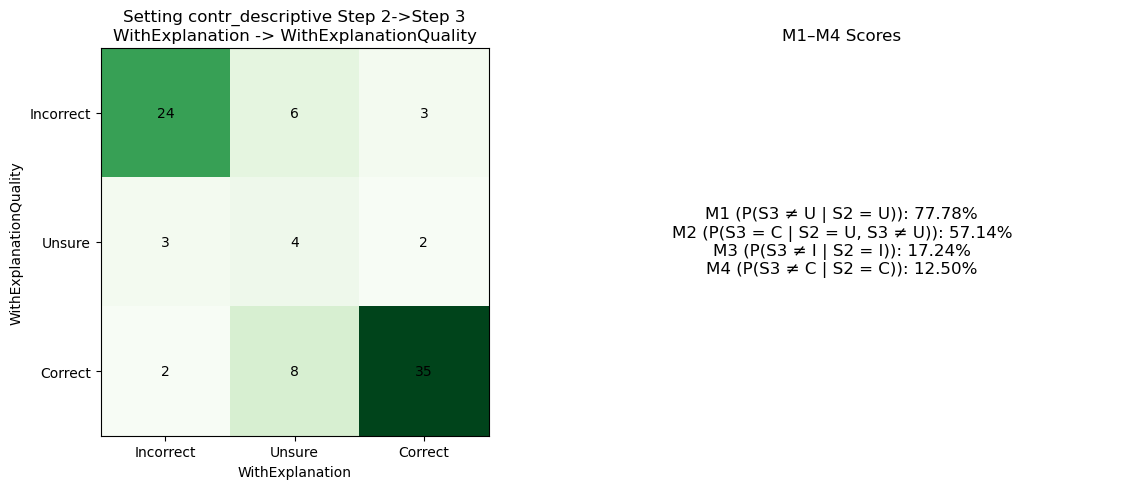

/tmp/ipykernel_26771/1609772469.py:331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])


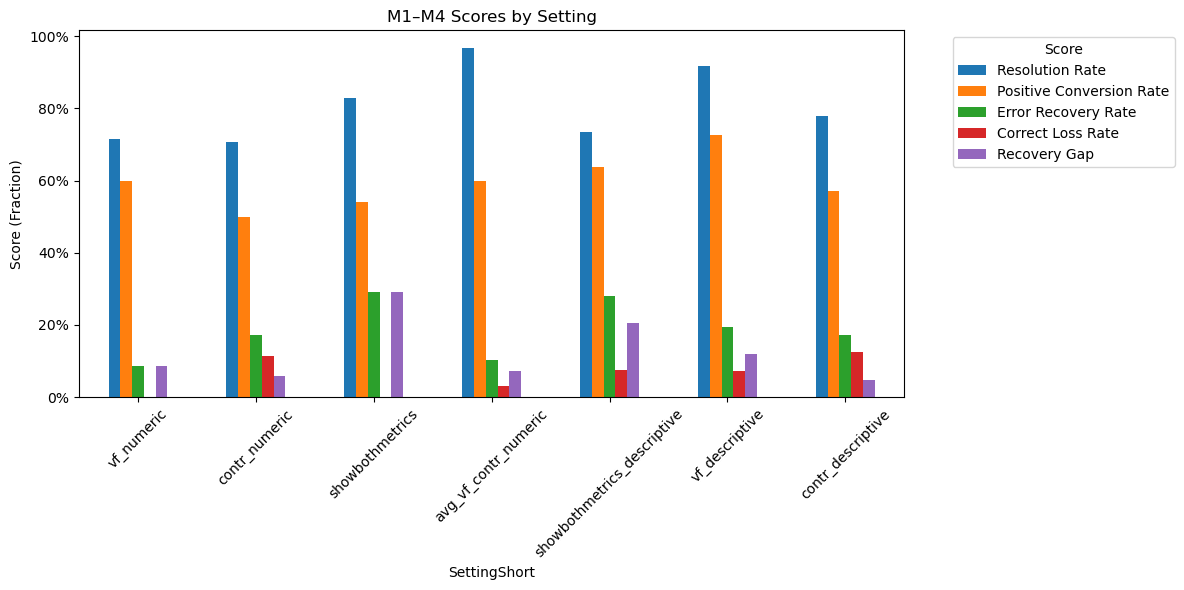

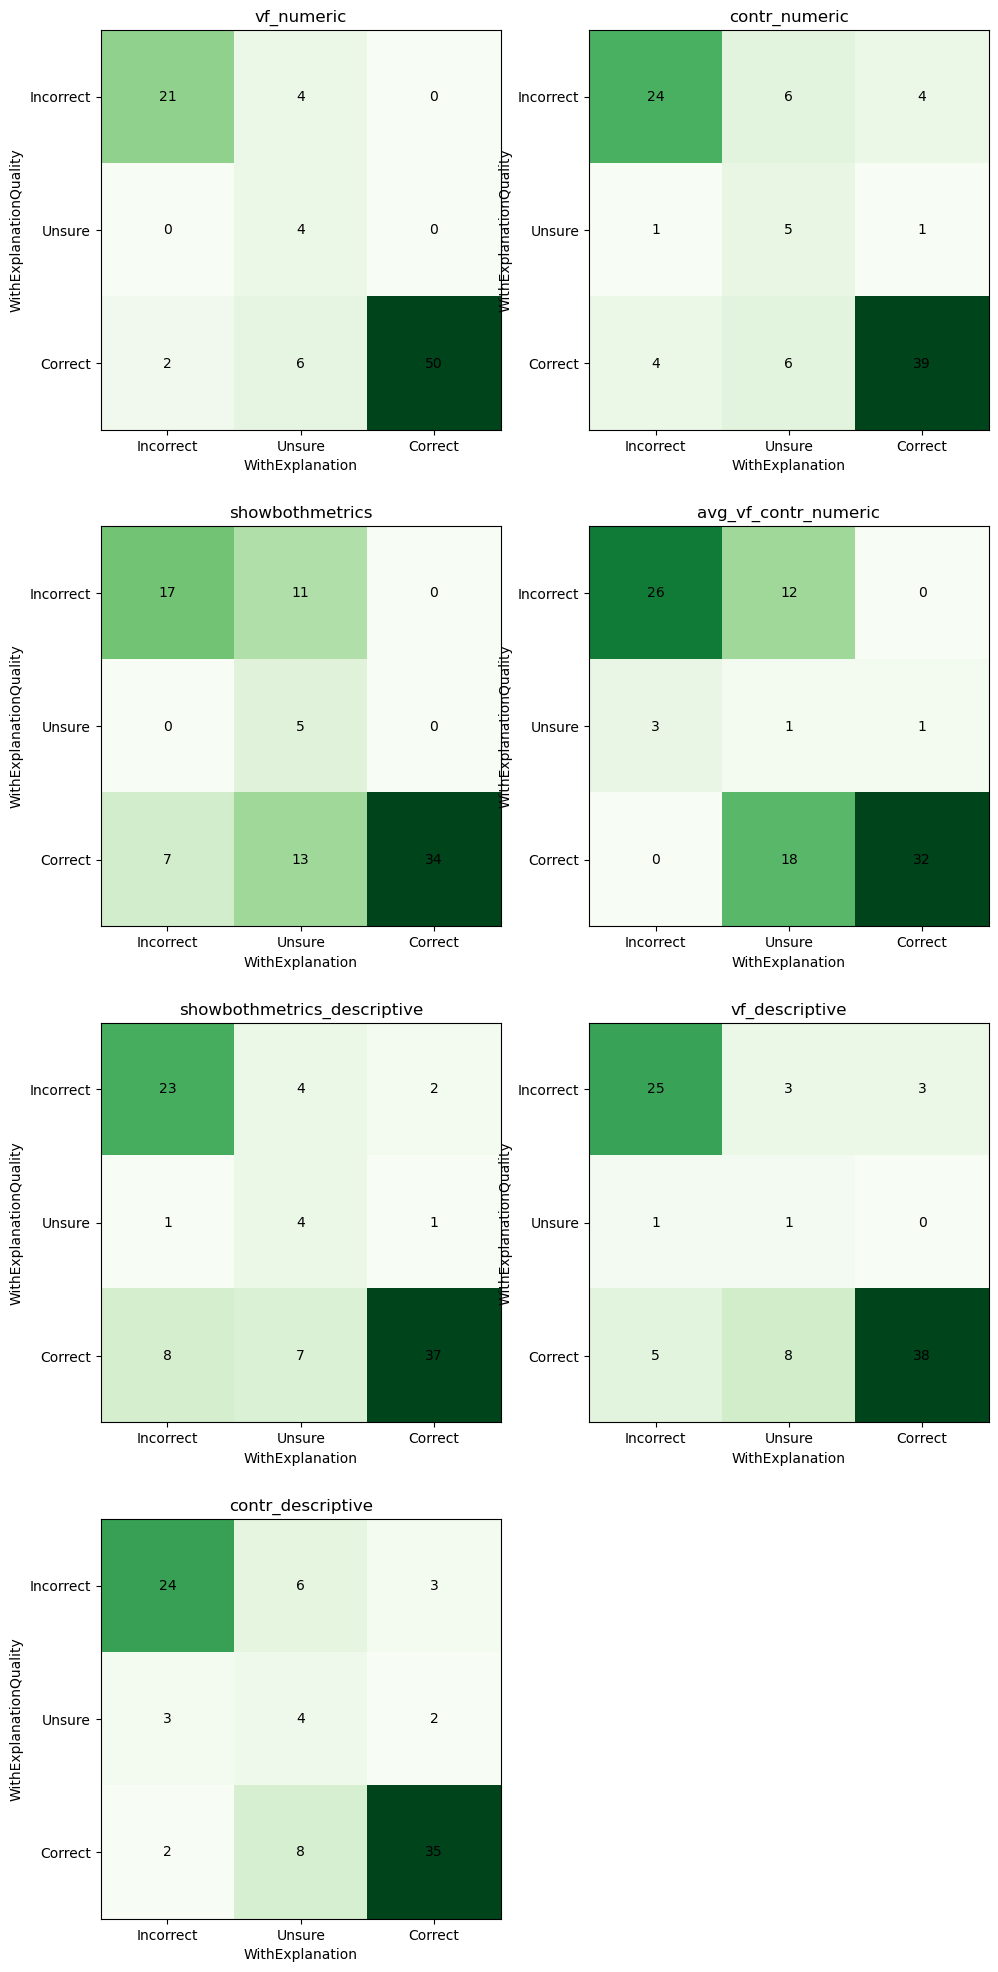

In [11]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(values):
    """Return the standard error of the given values."""
    n = len(values)
    return np.std(values, ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_unsure_rate(interactions, stage):
    """Compute the unsure rate (proportion of responses == 2) and its standard error."""
    preds = np.array([x['user_selections'][stage] for x in interactions])
    unsure_indicator = (preds == 2).astype(float)
    mean_unsure = np.mean(unsure_indicator)
    se_unsure = compute_se(unsure_indicator)
    return mean_unsure, se_unsure

def evaluate_answers(stage, instances):
    """
    For a given stage and list of interactions (instances), compute:
      - total accuracy (all instances, counting unsure as incorrect)
      - accuracy on non-unsure responses ("NotUnsureAcc")
      - unsure rate
      - utility (0 if unsure, 1 if correct, -1 if incorrect)
    Returns means and standard errors.
    """
    # Ground truth: 0 means AI is correct; 1 means AI is incorrect.
    ground_truths = np.array([1 - x['question']['prediction_is_correct'] for x in instances])
    preds = np.array([x['user_selections'][stage] for x in instances])
    
    # Total accuracy: count unsure (value 2) as incorrect.
    correct_all = ((preds != 2) & (preds == ground_truths)).astype(float)
    total_acc_mean = np.mean(correct_all)
    total_acc_se = compute_se(correct_all)
    
    # Accuracy for non-unsure responses.
    non_unsure_mask = (preds != 2)
    if np.sum(non_unsure_mask) > 0:
        correct_non_unsure = (preds[non_unsure_mask] == ground_truths[non_unsure_mask]).astype(float)
        acc_mean = np.mean(correct_non_unsure)
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan
    
    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_rate_mean = np.mean(unsure_indicator)
    unsure_rate_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; 1 if correct; -1 if incorrect.
    individual_utilities = np.array([
        0 if p == 2 else 1 - 2 * abs(p - gt)
        for p, gt in zip(preds, ground_truths)
    ])
    util_mean = np.mean(individual_utilities)
    util_se = compute_se(individual_utilities)
    
    return {
        'total_accuracy_mean': total_acc_mean,
        'total_accuracy_se': total_acc_se,
        'accuracy_mean': acc_mean,
        'accuracy_se': acc_se,
        'unsure_rate_mean': unsure_rate_mean,
        'unsure_rate_se': unsure_rate_se,
        'utility_mean': util_mean,
        'utility_se': util_se,
        'preds': preds,
        'ground_truths': ground_truths,
        'individual_utilities': individual_utilities,
    }

# ---------------------------
# Settings & Data Processing
# ---------------------------
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
]

USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# This list will collect the M1–M4 scores for each setting.
all_setting_scores = []

# This list will collect the confusion matrices for each setting.
all_confusion_matrices = []

# Define the consistency threshold (90%).
consistent_choice_threshold = 0.9

# Process each setting.
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Aggregate sessions for each user.
    data = {}  # key: user_id, value: list of sessions
    for file in files:
        with open(file) as f:
            batch_data = json.load(f)
            # Extract batch ID from the file name (e.g., "000", "001", etc.)
            batch_id = os.path.basename(file).split('.')[0]
            for user_id, session in batch_data.items():
                # Store the batch id with the session.
                session['batch'] = batch_id
                data.setdefault(user_id, []).append(session)
    total_users = len(data)
    total_attempts = sum(len(sessions) for sessions in data.values())
    print(f"Found {total_users} users in setting '{setting}' with {total_attempts} total attempts.")
    
    filtered_instances = []
    count_filtered_users = 0
    # Iterate through each user and aggregate responses across batches.
    for user, sessions in data.items():
        # Group interactions by batch
        grouped_interactions = {}
        for session in sessions:
            batch_id = session.get('batch', 'unknown')
            grouped_interactions.setdefault(batch_id, []).extend(session['interactions'])
        
        # For each batch, if answered more than 3 times, keep only the first 3 responses.
        user_interactions = []
        for batch_id, interactions_list in grouped_interactions.items():
            if len(interactions_list) > 3:
                # Drop the extra responses by keeping only the first three.
                trimmed_interactions = interactions_list[:3]
            else:
                trimmed_interactions = interactions_list
            user_interactions.extend(trimmed_interactions)
        
        # Build a list of all response values (across all stages) from the retained interactions.
        all_responses = []
        for interaction in user_interactions:
            for stage, response in interaction['user_selections'].items():
                all_responses.append(response)
        
        # Check consistency: if a user is overly consistent (≥90% same answer) they are filtered out.
        if len(all_responses) > 0:
            counts = np.bincount(all_responses, minlength=3)
            max_fraction = counts.max() / len(all_responses)
            if max_fraction < consistent_choice_threshold:
                filtered_instances.extend(user_interactions)
                count_filtered_users += 1
            else:
                # Also report the batches in which this user participated.
                user_batches = sorted({session.get('batch', 'unknown') for session in sessions})
                proportions = {str(choice): f"{(counts[choice]/len(all_responses))*100:.1f}%" 
                               for choice in range(len(counts))}
                print(f"User {user} filtered out in batches {user_batches}. Response distribution: {proportions}")
    print(f"{count_filtered_users} users remain after filtering (no single response selected ≥ 90% of the time).")
    
    if len(filtered_instances) == 0:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue

    # Evaluate each stage.
    answeronly_results = evaluate_answers('answeronly', filtered_instances)
    withexplanation_results = evaluate_answers('withexplanation', filtered_instances)
    withexplanationquality_results = evaluate_answers('withexplanationquality', filtered_instances)
    
    # ---------------------------
    # 1. Print Per-Stage Scores
    # ---------------------------
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    print("-" * 100)
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stage_results = [answeronly_results, withexplanation_results, withexplanationquality_results]
    
    csv_prints = []  # For copiable CSV outputs
    for name, res in zip(stage_names, stage_results):
        print(f"{name:<25}\t"
              f"{res['unsure_rate_mean']*100:5.1f}% ± {res['unsure_rate_se']*100:4.1f}%\t"
              f"{res['total_accuracy_mean']*100:5.1f}% ± {res['total_accuracy_se']*100:4.1f}%\t"
              f"{res['accuracy_mean']*100:5.1f}% ± {res['accuracy_se']*100:4.1f}%\t"
              f"{res['utility_mean']:+.3f} ± {res['utility_se']:.3f}")
        csv_prints.append(f"{res['unsure_rate_mean']*100:.1f}% ± {res['unsure_rate_se']*100:.1f}%, "
                          f"{res['total_accuracy_mean']*100:.1f}% ± {res['total_accuracy_se']*100:.1f}%, "
                          f"{res['accuracy_mean']*100:.1f}% ± {res['accuracy_se']*100:.1f}%, "
                          f"{res['utility_mean']:.3f} ± {res['utility_se']:.3f}")
        
    print(", ".join(csv_prints))
        
    # ---------------------------
    # 2. Print Utility Gains (Over Previous Stage)
    # ---------------------------
    explanation_gain = withexplanation_results['individual_utilities'] - answeronly_results['individual_utilities']
    quality_gain = withexplanationquality_results['individual_utilities'] - withexplanation_results['individual_utilities']
    
    expl_gain_mean = np.mean(explanation_gain)
    expl_gain_se = compute_se(explanation_gain)
    qual_gain_mean = np.mean(quality_gain)
    qual_gain_se = compute_se(quality_gain)
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    print(f"Explanation\t {withexplanation_results['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {withexplanationquality_results['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")

    # ---------------------------
    # 3. Compute Confusion Matrix & M1–M4 (Step 2 -> Step 3)
    # ---------------------------
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']

    cm = np.zeros((3, 3), dtype=int)
    for u2, u3 in zip(withexplanation_results['individual_utilities'], 
                      withexplanationquality_results['individual_utilities']):
        cm[mapping[u2], mapping[u3]] += 1

    cm_transposed = cm.T

    print(f"\nSetting: {setting} Step 2->Step 3 (transposed)")
    header = "\t\t" + "\t".join(label_names)
    print(header)
    for i, label in enumerate(label_names):
        row_counts = "\t\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_counts}")
        
    all_confusion_matrices.append((setting, cm_transposed))

    def count_transitions(val2, val3):
        return sum(1 for u2, u3 in zip(withexplanation_results['individual_utilities'],
                                        withexplanationquality_results['individual_utilities'])
                   if u2 == val2 and u3 == val3)

    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    
    # ---------------------------
    # NEW: Print Examples where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    example_count = 0
    for interaction in filtered_instances:
        stage2_pred = interaction['user_selections'].get('withexplanation')
        stage3_pred = interaction['user_selections'].get('withexplanationquality')
        ground_truth = 1 - interaction['question']['prediction_is_correct']
        if stage2_pred != 2 and stage2_pred == ground_truth and stage3_pred != 2 and stage3_pred != ground_truth:
            print(json.dumps(interaction, indent=2))
            example_count += 1
            if example_count >= 5:
                break
    if example_count == 0:
        print("No examples found.")

    # ---------------------------
    # 4. Plot Transposed Confusion Matrix & M1–M4 Scores
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\nWithExplanation -> WithExplanationQuality")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")

    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                  f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                  f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                  f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")

    plt.tight_layout()
    plt.show()

# ---------------------------
# 5. Plot Bar Plot for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    df_scores = df_scores.set_index("SettingShort")
    
    ax = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate", "Correct Loss Rate", "Recovery Gap"]].plot(
        kind='bar', figsize=(12, 6)
    )
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("M1–M4 Scores by Setting")
    vals = ax.get_yticks()
    
    ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])
    plt.xticks(rotation=45)
    
    plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
# ---------------------------
# 6. Plot a Large Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()
